In [2]:
import json
import os
from pyannote.audio import Audio as pyAudio
from pyannote.core import Segment
from speechbrain.inference.speaker import EncoderClassifier
import torch
from tqdm import tqdm

In [4]:

# Specify working directory (default: current dir - "speech_recognition_nmi_codes")
data_dir = './data'
audio_file = 'multi_speaker' # wav audio file with no file extension

with open(f'{os.path.join(data_dir, audio_file)}.json','r') as infile:
    lines = json.load(infile)

# Get audio segments from speech transcript
lines = [{'start':x['start'], 'end':x['end'], 'label':x['text']} for x in lines['segments'] if x['start'] < x['end']]

In [5]:

# For each audio segment, run encoding to get vector representation
# Use pretrained ECAPA-TDNN model for speech segment encoding
model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

audio_in = pyAudio()
for line in tqdm(lines):
    if line['start'] < line['end']:
        speaker = Segment(line['start'], line['end'])
        waveform, sample_rate = audio_in.crop(f'{os.path.join(data_dir, audio_file)}.wav', speaker)
        line['waveform'] = waveform
        line['sample_rate'] = sample_rate
        line['embedding'] = model(waveform) # 1x7205 tensor

embeddings = [x['embedding'][0][0] for x in lines if 'embedding' in x]
embeddings = torch.stack(embeddings, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:18<00:00,  6.21it/s]


In [6]:
# Use KMeans clustering to assign speaker labels

from sklearn.cluster import KMeans

n_speakers = 3
kmeans = KMeans(n_clusters=n_speakers)  # Adjust based on the expected number of speakers
speaker_labels = kmeans.fit_predict(embeddings)

for idx, label in enumerate(speaker_labels):
    lines[idx]['speaker'] = 'Speaker ' + str(label)

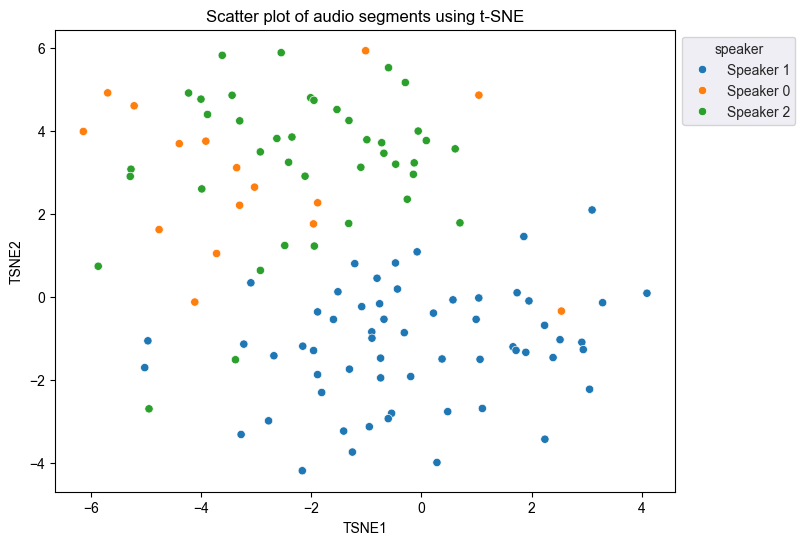

In [7]:
# Visualize via T-SNE plot (embeddings)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

tsne = TSNE(random_state=0, n_iter=1500)
tsne_results = tsne.fit_transform(embeddings)
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["speaker"] = [x['speaker'] for x in lines] # Add labels column from df_train to df_tsne

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='speaker')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of audio segments using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")        

plt.show()


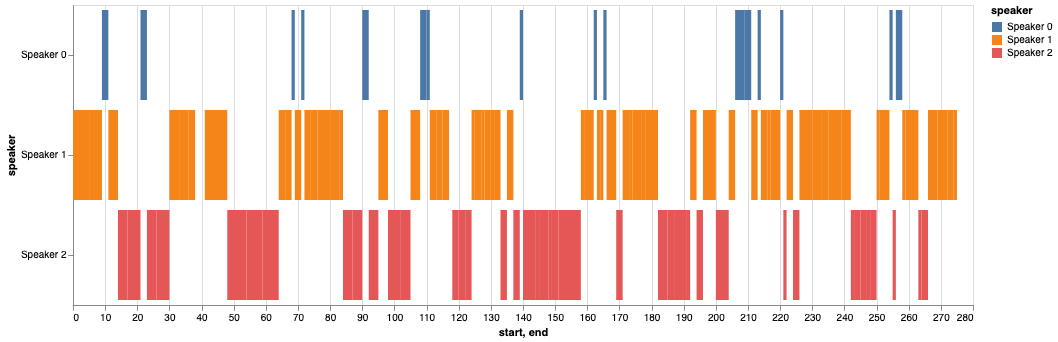

In [8]:
# Visualize segments and assigned speaker labels with audio duration

import altair as alt
import datetime as dt

alt.renderers.enable('jupyterlab')
segment_df = pd.DataFrame().from_dict(lines)[['start','end','speaker', 'label']]

alt.Chart(segment_df).mark_bar().encode(
    x='start',
    x2='end',
    y='speaker',
    color=alt.Color('speaker')).properties(
    width=900,
    height=300
)

In [9]:
# List down segments, speaker label, and audio player

from IPython.display import Audio, display, HTML
from ipywidgets import widgets

audio_data = [(line['waveform'],line['sample_rate'], line['label'], line['speaker']) for line in lines]
audio_widgets = []
for idx,(audio, sample_rate, label,speaker) in enumerate(audio_data):
    out = widgets.Output()
    with out:
        display(HTML(f'[Segment {idx}] <b>{speaker}</b> : {label} <br><br>'), Audio(data=audio, rate=sample_rate), HTML('<hr>'))
    audio_widgets.append(out)
widgets.VBox(audio_widgets)

In [34]:
# export to csv 
# start,end,speaker,label,recording

segment_df['recording'] = f'{os.path.join(data_dir,audio_file)}.wav'
segment_df.to_csv(f'{os.path.join(data_dir, audio_file)}.csv', index=False)
